In [1]:
!pip install yfinance
!pip install neuralprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 11.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

## Library

Import the libraries.

In [3]:
import yfinance as yf
import pandas as pd
from neuralprophet import NeuralProphet
from neuralprophet.utils import set_random_seed

Download the historical prices of the S&P500 index and prepare the DataFrame for modeling with NeuralProphet:

In [7]:
df = yf.download("^GSPC", start="2010-01-01", end="2022-12-31")
df = df[["Adj Close"]].reset_index(drop=False)
df.columns = ["ds", "y"]

[*********************100%***********************]  1 of 1 completed


Create train/test split:

In [8]:
TEST_LENGTH = 60
df_train = df.iloc[:-TEST_LENGTH]
df_test = df.iloc[-TEST_LENGTH:]

In [9]:
df_train.head(3)

,ds,y
0,2010-01-04,1132.989990
1,2010-01-05,1136.520020
2,2010-01-06,1137.140015


In [10]:
df_train.shape, df_test.shape

((3212, 2), (60, 2))

## Building and Improving Models

From this section and on, we keep building complexity of our NeuralProphet model to increase the test set performance.

In [11]:
set_random_seed(42)
model = NeuralProphet(changepoints_range=0.95)
metrics = model.fit(df_train, freq="B")

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.389% of the data.
INFO:NP.df_utils:Major frequency B corresponds to 96.389% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO:NP.df_utils:Defined frequency is equal to major frequency - B
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO:NP.config:Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 138
INFO:NP.config:Auto-set epochs to 138
/usr/local/lib/p

Finding best initial lr:   0%|          | 0/238 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f965e725580>,
      dtype=object)

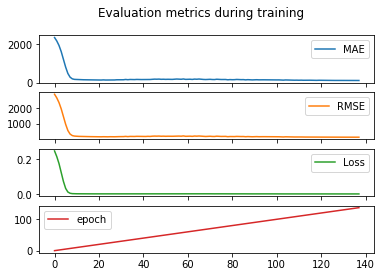

In [12]:
(
    metrics.drop(columns=["RegLoss"]).plot(
        title="Evaluation metrics during training", 
        subplots = True
    )
)

Calculuate the predictions and plot the fit.

In [13]:
pred_df = model.predict(df)
pred_df.shape

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.394% of the data.
INFO:NP.df_utils:Major frequency B corresponds to 96.394% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO:NP.df_utils:Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.394% of the data.
INFO:NP.df_utils:Major frequency B corresponds to 96.394% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO:NP.df_utils:Defined frequency is equal to major frequency - B


Predicting: 101it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


(3272, 6)

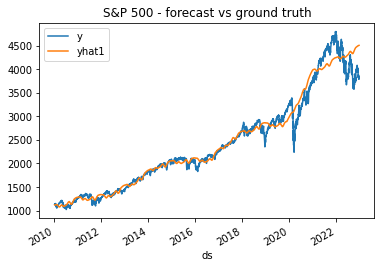

In [14]:
pred_df.plot(
    x="ds",
    y=["y", "yhat1"],
    title="S&P 500 - forecast vs ground truth"
)

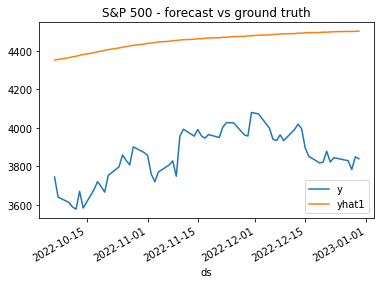

In [15]:
(
    pred_df.iloc[-TEST_LENGTH:].plot(
        x="ds",
        y=["y", "yhat1"],
        title="S&P 500 - forecast vs ground truth"
    )
)

Add the AR components to NeuralProphet:

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.389% of the data.
INFO:NP.df_utils:Major frequency B corresponds to 96.389% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO:NP.df_utils:Defined frequency is equal to major frequency - B
INFO - (NP.forecaster.__handle_missing_data) - 116 missing dates added.
INFO:NP.forecaster:116 missing dates added.
WARNING - (NP.forecaster.__handle_missing_data) - 116 missing values in column y were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 116 NaN values in column y were auto-imputed.
INFO:NP.forecaster:116 NaN values in column y were auto-imputed.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet w

Finding best initial lr:   0%|          | 0/238 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.394% of the data.
INFO:NP.df_utils:Major frequency B corresponds to 96.394% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO:NP.df_utils:Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.395% of the data.
INFO:NP.df_utils:Major frequency B corresponds to 96.395% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO:NP.df_utils:Defined frequency is equal to major frequency - B
INFO - (NP.forecaster.__handle_missing_data) - 118 missing dates added.
INFO:NP.forecaster:118 missing dates added.
WARNING - (NP.forecaster.__handle_missing_data) - 118 missing values in column y were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 118 NaN values in column y were auto-imputed.
INFO:NP.forecaster:118 NaN values in colu

Predicting: 104it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


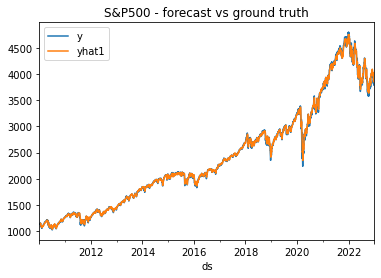

In [17]:
set_random_seed(42)
model = NeuralProphet(
    changepoints_range=0.95,
    n_lags=10,
    ar_reg=1,
)

metrics = model.fit(df_train, freq="B")

pred_df = model.predict(df)
pred_df.plot(x="ds", y=["y", "yhat1"],
             title="S&P500 - forecast vs ground truth")

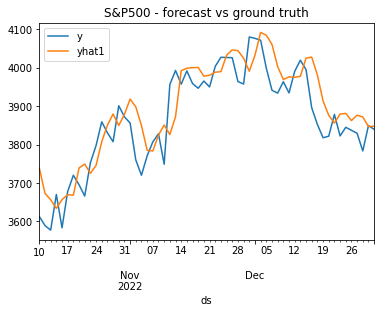

In [18]:
pred_df.iloc[-TEST_LENGTH:].plot(x="ds", y=["y", "yhat1"],
                                 title="S&P500 - forecast vs ground truth")

Add the AR-Net to NeuralProphet:

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.389% of the data.
INFO:NP.df_utils:Major frequency B corresponds to 96.389% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO:NP.df_utils:Defined frequency is equal to major frequency - B
INFO - (NP.forecaster.__handle_missing_data) - 116 missing dates added.
INFO:NP.forecaster:116 missing dates added.
WARNING - (NP.forecaster.__handle_missing_data) - 116 missing values in column y were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 116 NaN values in column y were auto-imputed.
INFO:NP.forecaster:116 NaN values in column y were auto-imputed.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet w

Finding best initial lr:   0%|          | 0/238 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.394% of the data.
INFO:NP.df_utils:Major frequency B corresponds to 96.394% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO:NP.df_utils:Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.395% of the data.
INFO:NP.df_utils:Major frequency B corresponds to 96.395% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO:NP.df_utils:Defined frequency is equal to major frequency - B
INFO - (NP.forecaster.__handle_missing_data) - 118 missing dates added.
INFO:NP.forecaster:118 missing dates added.
WARNING - (NP.forecaster.__handle_missing_data) - 118 missing values in column y were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 118 NaN values in column y were auto-imputed.
INFO:NP.forecaster:118 NaN values in colu

Predicting: 104it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


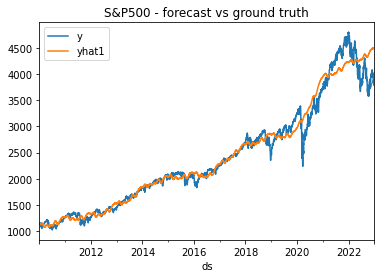

In [21]:
set_random_seed(42)
model = NeuralProphet(
    changepoints_range=0.95,
    n_lags=10,
    ar_reg=1,
    num_hidden_layers=3,
    d_hidden=32
)

metrics = model.fit(df_train, freq="B")

pred_df = model.predict(df)
pred_df.plot(x="ds", y=["y", "yhat1"],
             title="S&P500 - forecast vs ground truth")

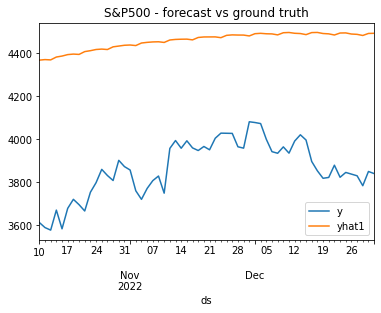

In [23]:
pred_df.iloc[-TEST_LENGTH:].plot(x="ds", y=["y", "yhat1"],
                                 title="S&P500 - forecast vs ground truth")

## Explainability

From here, we plot the components and parameters of the model. There are snippets of subplots generated from different components of the model such as yearly trend, monthly trend, weekly trend, and so on.

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.389% of the data.
INFO:NP.df_utils:Major frequency B corresponds to 96.389% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO:NP.df_utils:Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.39% of the data.
INFO:NP.df_utils:Major frequency B corresponds to 96.39% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO:NP.df_utils:Defined frequency is equal to major frequency - B
INFO - (NP.forecaster.__handle_missing_data) - 116 missing dates added.
INFO:NP.forecaster:116 missing dates added.
WARNING - (NP.forecaster.__handle_missing_data) - 116 missing values in column y were detected in total. 
INFO - (NP.forecaster.__handle_missing_data) - 116 NaN values in column y were auto-imputed.
INFO:NP.forecaster:116 NaN values in column

Predicting: 104it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


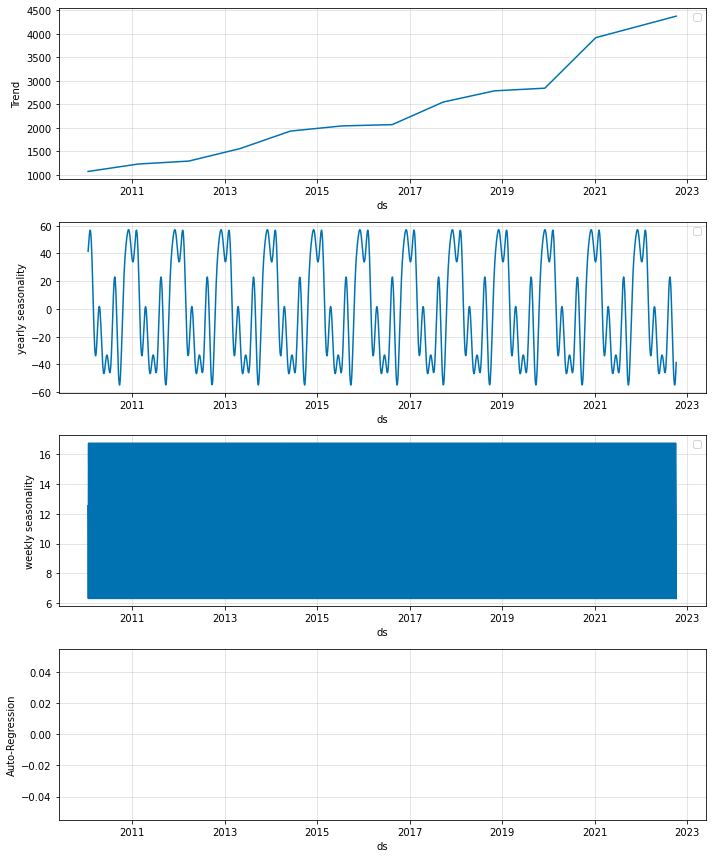

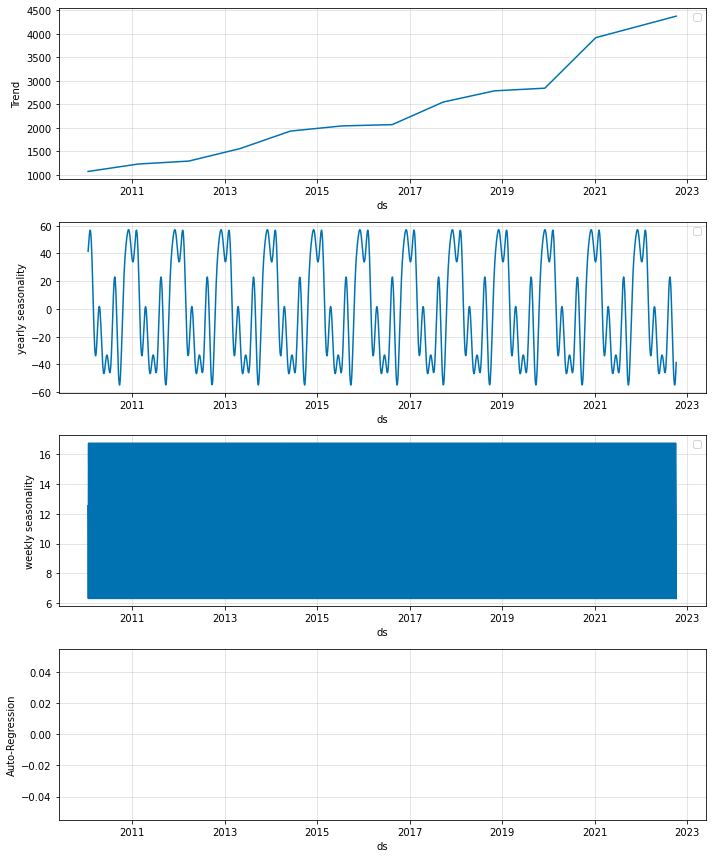

In [22]:
model.plot_components(model.predict(df_train))